In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

Our likelihood function is

$$p(y | X, \beta ,\sigma^2) \propto (\sigma^2)^{-n/2} \exp \left[-\frac{1}{2\sigma^2} (y-X\beta)^T (y-X\beta) \right] $$

Taking our priors as $\pi(\sigma^2) \propto \frac{1}{\sigma^2}$ and $\pi(\beta) \propto 1$ gives the posterior:

$$p(\sigma^2, \beta | x, y) \propto  (\sigma^2)^{-n/2 - 1} \exp \left[-\frac{1}{2\sigma^2} (y-X\beta)^T (y-X\beta) \right] $$

$$p(\beta |y, X ,\Sigma) \propto \exp \left[-\frac{1}{2\sigma^2} (y-X\beta)^T(y-X\beta) \right] $$

$$p(\sigma^2 | y, X, \beta) \propto (\sigma^2)^{-n/2 - 1} \exp \left[-\frac{1}{2\sigma^2} (y-X\beta)^T (y-X\beta) \right] $$

$$\sigma^2 | y, X, \beta \sim IG \left(\frac{n}{2}, \frac{(y-X\beta)^T (y-X\beta)}{2} \right)$$


In [3]:
df = pd.read_csv('student-mat.csv', sep=",")

In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
X = df[['age', 'famrel', 'freetime', 'goout', 'G1', 'G2']].copy()
X['intercept'] = 1
y = df['G3']

In [6]:
from model_code import MH_regression

In [7]:
np.random.seed(seed=870)
betas, accept = MH_regression(X, y, 20, 3)
print(np.mean(accept))

0.0


## Choosing explanatory variables 

In [8]:
category = ["sex", "Mjob", "Fjob", "school", "address", "Pstatus", 
           "reason", "guardian", "schoolsup", "famsup", "paid", "famsize",
            "activities", "nursery", "higher", "internet", "romantic"]
numeric = ["age", "absences", "Medu", "Fedu", "traveltime", 
           "studytime", "failures", "famrel", "freetime", "goout", "Dalc", 
           "Walc", "health", "G1", "G2", "G3"]

In [9]:
df[numeric] = df[numeric].astype(int) 
df = pd.get_dummies(df, drop_first=True)

In [10]:
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,0,1,1,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,0,1,1,0,1,1,0,0


In [11]:
df.corr()["G3"]

age                 -0.161579
Medu                 0.217147
Fedu                 0.152457
traveltime          -0.117142
studytime            0.097820
failures            -0.360415
famrel               0.051363
freetime             0.011307
goout               -0.132791
Dalc                -0.054660
Walc                -0.051939
health              -0.061335
absences             0.034247
G1                   0.801468
G2                   0.904868
G3                   1.000000
school_MS           -0.045017
sex_M                0.103456
address_U            0.105756
famsize_LE3          0.081407
Pstatus_T           -0.058009
Mjob_health          0.116158
Mjob_other          -0.096477
Mjob_services        0.078429
Mjob_teacher         0.057712
Fjob_health          0.057111
Fjob_other          -0.053483
Fjob_services       -0.016108
Fjob_teacher         0.095374
reason_home         -0.021359
reason_other         0.052008
reason_reputation    0.095692
guardian_mother      0.022338
guardian_o

Suggesting for now:

We can let higher_yes and failures be the variables with missing data.
And using all the rest. Let $\mathbf{X}$ be the design matrix, including the variables with missing data. Let $\mathbf{X_J}$ be the design matrix, excluding the variables with missing data.

$$\mathbf{Y} \sim MVN(\mathbf{X}\beta, \mathbf{I}\sigma^2)$$
$$X_{\text{higher_yes}} \sim Bernoulli(p_1)$$ 
$$X_{\text{failures}} \sim Binomial(N, p_2)$$ 
$$\pi(\sigma^2) \propto \frac{1}{\sigma^2}$$
$$\pi(\beta)\propto 1$$

Assuming $X_{\text{higher_yes}}, X_{\text{failures}}, \sigma^2, \beta$ are independent we have 

$$p(X_{\text{higher_yes}}, X_{\text{failures}}, \sigma^2, \beta|\mathbf{X_J}, \mathbf{Y})$$

$$\propto L(\mathbf{Y}|\mathbf{X_J}, X_{\text{higher_yes}}, X_{\text{failures}}, \sigma^2, \beta)\pi(X_{\text{higher_yes}}|\mathbf{X_J}, X_{\text{failures}}, \sigma^2, \beta)\pi(X_{\text{failures}}|\mathbf{X_J}, X_{\text{higher_yes}},  \sigma^2, \beta)\pi(\beta|\mathbf{X_J}, \sigma^2)\pi(\sigma^2| \mathbf{X_J})$$

$$\propto L(\mathbf{Y}|\mathbf{X_J}, X_{\text{higher_yes}}, X_{\text{failures}}, \sigma^2, \beta)\pi(X_{\text{higher_yes}}|\mathbf{X_J})\pi(X_{\text{failures}}|\mathbf{X_J})\pi(\beta|\mathbf{X_J})\pi(\sigma^2| \mathbf{X_J})$$

In [12]:
https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html

SyntaxError: invalid syntax (<ipython-input-12-ac5e00be15e6>, line 1)

To model the missing covariates, we can consider $\text{Higher_yes}|\text{Age}$ to be a binary model.

$\text{Higher_yes}_i|\text{Age}_i \sim \text{Bernoulli}(\phi_i)$ where

$$\phi_i=\frac{\exp [ \alpha_0 + \alpha_1 \text{Age}_i]}{1+\exp [ \alpha_0 + \alpha_1 \text{Age}_i]} \in [0,1]$$

And $\alpha_0, \alpha_1$ are given normal priors with large variance.

$\text{Absences}|\text{Age}$ can be considered a count model.

$$\text{Absences}_i|\text{Age}_i \sim \text{Poisson}(\mu)$$ where

$$\mu_i=\exp [\gamma_0 + \gamma_1\text{Age}_i] > 0$$

And $\gamma_0, \gamma_1$ are given normal priors with large variance.

The regression parameters are given the following priors

$$\pi(\sigma^2) \propto \frac{1}{\sigma^2}$$
$$\pi(\beta)\propto 1$$

Our parameters are then $\alpha_0, \alpha_1, \gamma_0, \gamma_1, \text{Absences}_i, \text{Higher_yes}_i$ (parameters for modeling the missing covariates) and $\beta, \sigma^2$ (regression parameters). The full posterior would be the product of: 


$$p(y | X, \beta ,\sigma^2) \propto (\sigma^2)^{-n/2} \exp \left[-\frac{1}{2\sigma^2} (y-X\beta)^T (y-X\beta) \right]$$
$$\pi(\sigma^2) \propto \frac{1}{\sigma^2}$$
$$\pi(\beta)\propto 1$$
$$\prod_{i=1}^n p(\text{Absences}_i|\text{Age}_i)$$
$$\prod_{i=1}^np(\text{Higher_yes}_i|\text{Age}_i)$$
$$N(0, 100) ~~\text{for example for each of}~~ \alpha_0, \alpha_1, \gamma_0, \gamma_1$$

<AxesSubplot:ylabel='Frequency'>

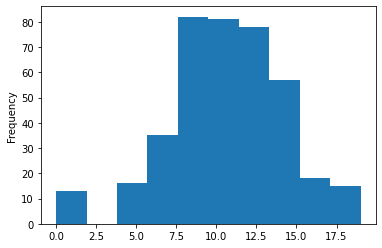

In [17]:
df["G2"].plot.hist()

PYMC example of hierarchical model:
https://docs.pymc.io/notebooks/GLM-hierarchical.html